In [ ]:
# Download Packages
!pip install xgboost
!pip install seaborn
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install glob
!pip install matplotlib
!pip install sklearn
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install pillow
!pip install imutils


In [ ]:
!pip install --upgrade tensorflow

Processing training data...


Processing test data...

Training XGBoost model...

Accuracy: 0.8028846153846154


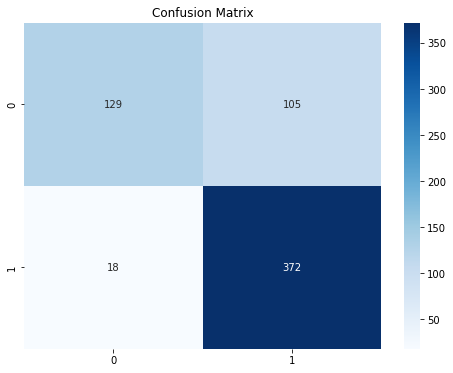


Sample Prediction:
Predicted: PNEUMONIA
Actual: PNEUMONIA

Models saved successfully!


In [2]:
# Import libraries
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
import xgboost as xgb
import joblib

# Set up matplotlib for Jupyter
%matplotlib inline

#---------------------------------------------------------------
# Configuration
#---------------------------------------------------------------
BASE_DIR = "./chest-xray-pneumonia-detection-master/dataset/chest_xray"
SIZE = 224
BATCH_SIZE = 8
FEATURE_BATCH_SIZE = 32

#---------------------------------------------------------------
# Memory Optimization
#---------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

#---------------------------------------------------------------
# Data Processing Functions
#---------------------------------------------------------------
def process_dataset(directory, encoder, feature_extractor):
    features = []
    labels = []
    
    for class_dir in glob.glob(os.path.join(directory, "*")):
        label = os.path.basename(class_dir)
        paths = glob.glob(os.path.join(class_dir, "*.jpg")) + \
                glob.glob(os.path.join(class_dir, "*.jpeg"))
        
        for i in range(0, len(paths), BATCH_SIZE):
            batch_images = []
            batch_paths = paths[i:i+BATCH_SIZE]
            
            for path in batch_paths:
                img = cv2.imread(path)
                if img is None:
                    continue
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                batch_images.append(img.astype(np.float32)/255.0)
            
            if batch_images:
                batch_features = feature_extractor.predict(np.array(batch_images), verbose=0)
                features.append(batch_features)
                labels.extend([label] * len(batch_images))
                
                del batch_images, batch_features
                tf.keras.backend.clear_session()
                
            if len(features) >= FEATURE_BATCH_SIZE:
                yield np.vstack(features), encoder.transform(labels)
                features.clear()
                labels.clear()
    
    if len(features) > 0:
        yield np.vstack(features), encoder.transform(labels)

#---------------------------------------------------------------
# Main Execution
#---------------------------------------------------------------
def main():
    # Initialize label encoder
    le = preprocessing.LabelEncoder()
    le.fit(["NORMAL", "PNEUMONIA"])
    
    # Verify dataset
    train_dir = os.path.join(BASE_DIR, "train")
    test_dir = os.path.join(BASE_DIR, "test")
    for d in [train_dir, test_dir]:
        if not os.path.exists(d):
            raise FileNotFoundError(f"Directory not found: {d}")

    # Create feature extractor
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=x)
    
    # Process training data
    print("Processing training data...")
    train_features, train_labels = [], []
    for features, labels in process_dataset(train_dir, le, feature_extractor):
        train_features.append(features)
        train_labels.append(labels)
    train_features = np.vstack(train_features)
    train_labels = np.concatenate(train_labels)
    
    # Process test data
    print("\nProcessing test data...")
    test_features, test_labels = [], []
    for features, labels in process_dataset(test_dir, le, feature_extractor):
        test_features.append(features)
        test_labels.append(labels)
    test_features = np.vstack(test_features)
    test_labels = np.concatenate(test_labels)
    
    # Calculate class weights
    class_counts = np.bincount(train_labels)
    scale_pos_weight = class_counts[0]/class_counts[1]  # NORMAL/PNEUMONIA
    
    # Train classifier
    print("\nTraining XGBoost model...")
    model = xgb.XGBClassifier(
        tree_method='hist',
        device='cuda' if gpus else 'cpu',
        scale_pos_weight=scale_pos_weight,
        n_estimators=200,
        learning_rate=0.01
    )
    model.fit(train_features, train_labels)
    
    # Evaluate with adjusted threshold
    probs = model.predict_proba(test_features)[:, 1]
    predictions = (probs > 0.6).astype(int)  # Reduced FP
    print("\nAccuracy:", accuracy_score(test_labels, predictions))
    
    # Confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(le.inverse_transform(test_labels), 
                le.inverse_transform(predictions)),
                annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    
    # Sample prediction
    sample_idx = np.random.randint(0, len(test_features))
    print("\nSample Prediction:")
    print("Predicted:", le.inverse_transform([predictions[sample_idx]])[0])
    print("Actual:", le.inverse_transform([test_labels[sample_idx]])[0])
    
    return model, le  # Return for saving

if __name__ == "__main__":
    trained_model, label_encoder = main()
    
    # Save models in a separate operation
    joblib.dump(trained_model, "xgb_pneumonia.pkl")
    joblib.dump(label_encoder, "label_encoder.pkl")
    print("\nModels saved successfully!")